### CREDIT

This notebook is prepared by the guidance of  Margaret Maynard-Reid's blogs from Pyimagesearch. Most of the code blocks and explanations are taken from these blogs. You can reach original codes and detailed explanations from references.

#### WHAT IS THIS NOTEBOOK

This notebook is an example about DCGAN by keras and TF. We will implement DCGAN for Clothing & Models from Kaggle , based on the paper, Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks (Radford et al., 2016).


#### Keywords

* DCGAN
* GAN
* TF 
* Clothing & Models from Kaggle


In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from matplotlib import pyplot as plt

In [4]:
dataset=r'C:\Users\Zeki\Desktop\kisisel calismalar\datasets\zalando'

In [6]:
train_images = tf.keras.utils.image_dataset_from_directory(
    dataset, label_mode=None, image_size=(64, 64), batch_size=32)

Found 16180 files belonging to 1 classes.


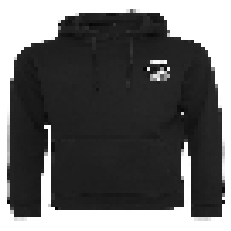

In [7]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")
plt.axis("off")
plt.imshow(random_image)
plt.show()

In [8]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

In [9]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3

In [10]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name='generator')

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    # model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # layers.LeakyReLU(alpha=0.2),

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((8, 8, 512)))

    # upsample to 16x16: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 32x32: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 64x64: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    # return the generator model
    return model

In [11]:
# build the generator model
generator = build_generator() 

In [12]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      524416    
 ranspose)                                               

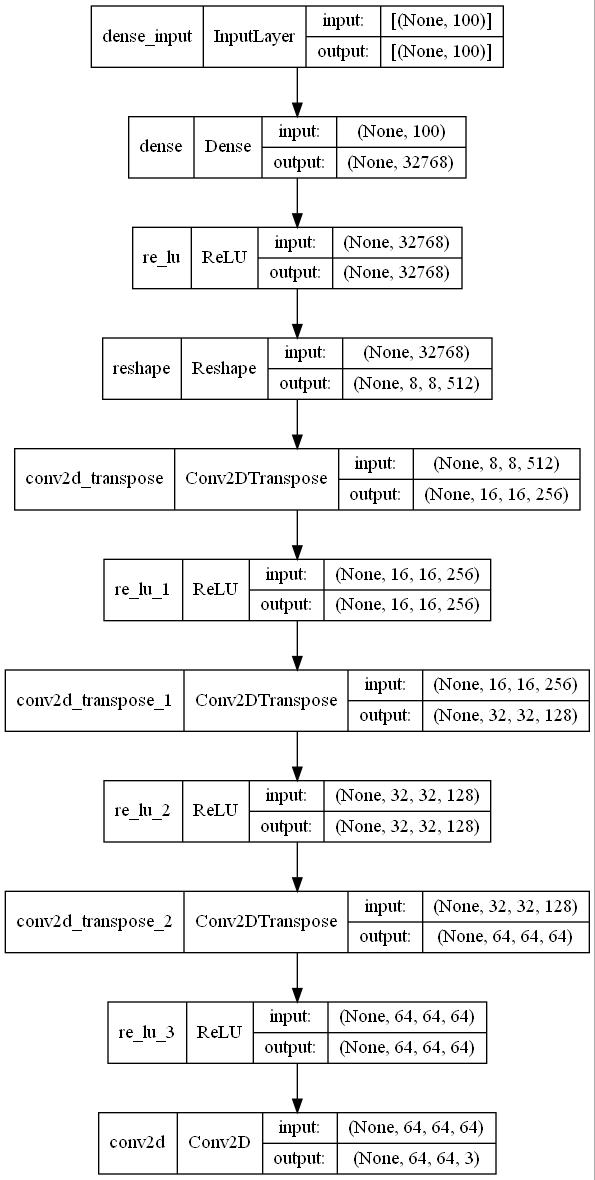

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(generator, show_shapes=True, show_layer_names=True, to_file='generator_DCGAN_COLORFUL.jpg')

In [14]:
def build_discriminator(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), padding="same", strides=(2, 2),
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputting a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [15]:
# build the discriminator model
discriminator = build_discriminator(64, 64, 3) 

In [16]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

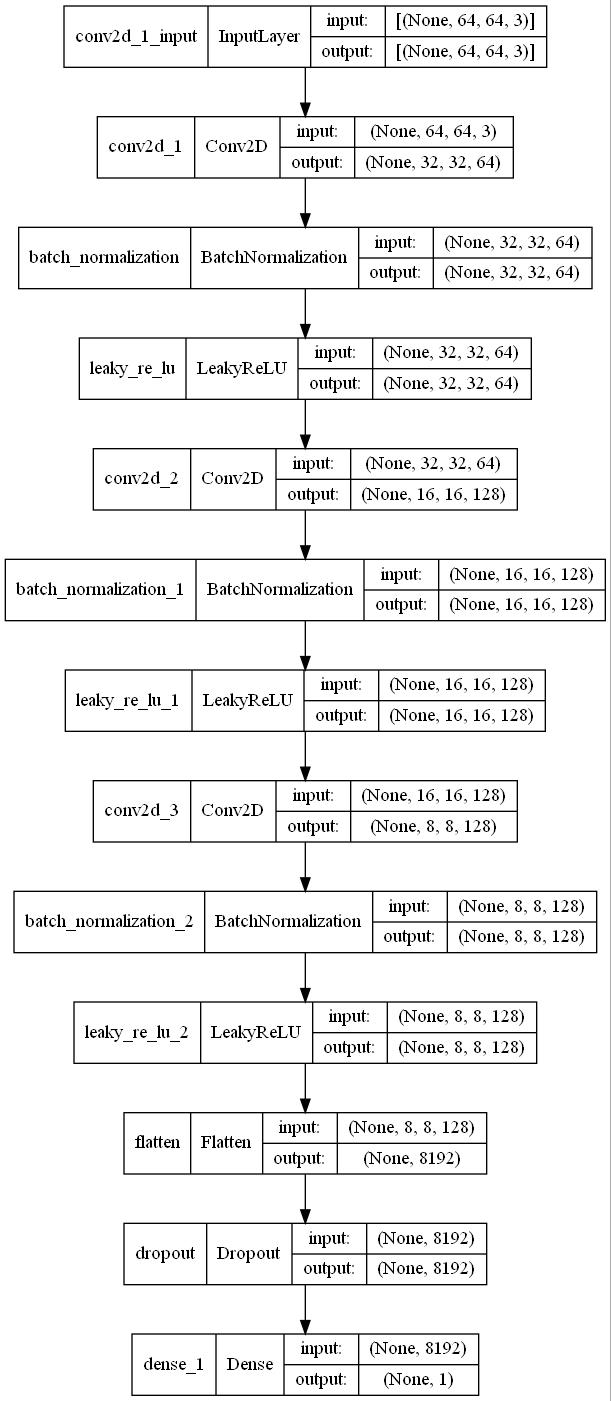

In [17]:
plot_model(discriminator, show_shapes=True, show_layer_names=True, to_file='discriminator_DCGAN_COLORFUL.jpg')

In [18]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            # UPDATED: apply one-sided label smoothing to real labels
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels)) 
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            # UPDATED: add random noise to fake labels - not needed
            # fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels)) 
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [19]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator_COLORFUL.h5')

In [20]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

In [21]:
D_LR = 0.0001 # UPDATED: discriminator learning rate
G_LR = 0.0003 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Epoch 1/50
506/506 [==============================] - ETA: 0s - d_loss: 0.6336 - g_loss: 2.9134

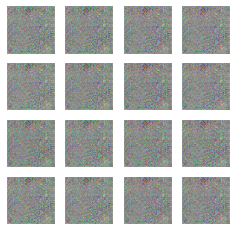

506/506 [==============================] - 40s 72ms/step - d_loss: 0.6336 - g_loss: 2.9134
Epoch 2/50
506/506 [==============================] - ETA: 0s - d_loss: 0.2169 - g_loss: 3.4986 ETA: 0s - d_loss: 0.2129 - 

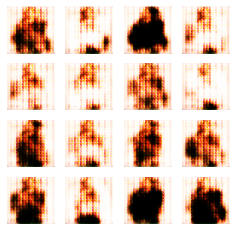

506/506 [==============================] - 37s 73ms/step - d_loss: 0.2169 - g_loss: 3.4986
Epoch 3/50
506/506 [==============================] - ETA: 0s - d_loss: 0.3452 - g_loss: 2.3574

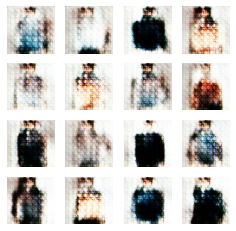

506/506 [==============================] - 38s 74ms/step - d_loss: 0.3452 - g_loss: 2.3574
Epoch 4/50
506/506 [==============================] - ETA: 0s - d_loss: 0.3549 - g_loss: 2.2623

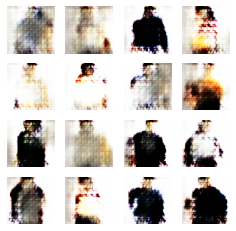

506/506 [==============================] - 38s 74ms/step - d_loss: 0.3549 - g_loss: 2.2623
Epoch 5/50
506/506 [==============================] - ETA: 0s - d_loss: 0.3404 - g_loss: 2.1948

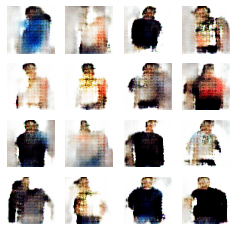

506/506 [==============================] - 38s 74ms/step - d_loss: 0.3404 - g_loss: 2.1948
Epoch 6/50
506/506 [==============================] - ETA: 0s - d_loss: 0.4132 - g_loss: 1.8846

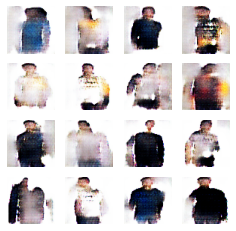

506/506 [==============================] - 38s 75ms/step - d_loss: 0.4132 - g_loss: 1.8846
Epoch 7/50
506/506 [==============================] - ETA: 0s - d_loss: 0.4684 - g_loss: 1.6236

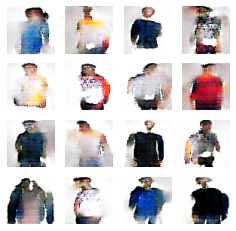

506/506 [==============================] - 38s 75ms/step - d_loss: 0.4684 - g_loss: 1.6236
Epoch 8/50
506/506 [==============================] - ETA: 0s - d_loss: 0.4905 - g_loss: 1.5616

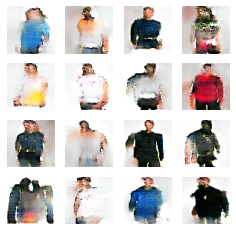

506/506 [==============================] - 38s 74ms/step - d_loss: 0.4905 - g_loss: 1.5616
Epoch 9/50
506/506 [==============================] - ETA: 0s - d_loss: 0.5314 - g_loss: 1.4797

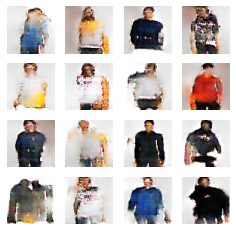

506/506 [==============================] - 38s 75ms/step - d_loss: 0.5314 - g_loss: 1.4797
Epoch 10/50
273/506 [===============>..............] - ETA: 17s - d_loss: 0.5683 - g_loss: 1.4087

KeyboardInterrupt: 

In [22]:
NUM_EPOCHS = 50 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

#### !!! It is a time-consuming process... I interrupted the kernel, because my main purpose to show 'how to train' and improvemnet on the model after each iteration..

### PART 2_ USE THE GENERATOR

After training, we have a generator model. We will create a noise with (1,100) and use it as an input for our model... And our generator will give us an image of a cloth...Let's see it.

In [23]:
from tensorflow.keras.models import load_model
noise = tf.random.normal(shape=(1, 100))
gen=load_model('generator_COLORFUL.h5')

In [24]:
A=gen.predict(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


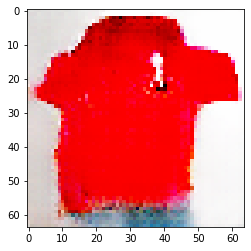

In [25]:
plt.figure()
plt.imshow(A[0], cmap='gray')
plt.show()

REFERENCES : 

Maynard-Reid, M. “GAN Training Challenges: DCGAN for Color Images,” PyImageSearch, 2021, https://pyimagesearch.com/2021/12/13/gan-training-challenges-dcgan-for-color-images/

https://arxiv.org/pdf/1511.06434.pdf